In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
results_51peg = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5


In [3]:
data_51peg = wobble.Data('51peg_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/')

/Users/mbedell/python/wobble/wobble/data.py:107: RuntimeWarning: invalid value encountered in multiply
  self.ivars = [self.fluxes[i]**2 * self.flux_ivars[i] for i in range(self.R)] # ivars for log(fluxes)


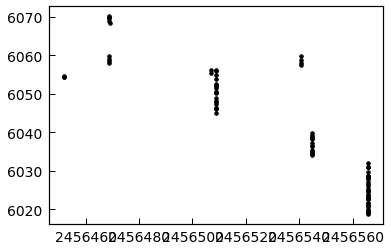

In [5]:
plt.plot(results_51peg.dates, results_51peg.star_time_rvs + results_51peg.bervs, 'k.')

In [227]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

Mstar = 1.11 # Msun
Rstar = 1.27 # Rsun
Rp = 1.9 # Rjup

In [228]:
t, rv, rv_err = results_51peg.dates, results_51peg.star_time_rvs + results_51peg.bervs, results_51peg.star_time_sigmas
t -= np.median(t)

with pm.Model() as model:

    # Parameters
    logK = pm.Normal("logK", mu=np.log(55.11), sd=10.0)
    P = pm.Normal("P", mu=4.23078, sd=0.001)
    t0 = pm.Normal("t0", mu=np.median(t)+2., sd=50.)
    ecc = pm.Uniform("e", lower=0, upper=.99, testval=0.001)
    omega = xo.distributions.Angle("omega", testval=0.)
    logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    rv0 = pm.Normal("rv0", mu=0.0, sd=20.0, testval=0.)
    
    # Sanity check bounds
    pm.Potential("logK_bound", tt.switch(logK < -2., -np.inf, 0.0))
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Deterministic transformations
    K = pm.Deterministic("K", tt.exp(logK))
    s2 = tt.exp(2*logs)
    Mp = pm.Deterministic("Mp", K * tt.sqrt(1. - ecc**2.) * Mstar**(-2./3.) * P**(1./3.) / 203.) # assumes Mp << Mstar

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega,
        r_star=Rstar, m_star=Mstar)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(t, K=K)
    pm.Deterministic("vrad", vrad)
    
    bkg = pm.Deterministic("bkg", rv0) # just in case...    
    rv_model = pm.Deterministic("rv_model", vrad + bkg)
    
    t_all = np.linspace(t.min()-5, t.max()+5, 1000)
    vrad_pred = orbit.get_radial_velocity(t_all, K=K)
    pm.Deterministic("vrad_pred", vrad_pred)
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     vrad_pred + bkg)

    # Compute the phased RV signal
    phase = np.linspace(-0.1, 1.1, 500)
    rvphase = orbit.get_radial_velocity(phase * P, K=K)
    pm.Deterministic("rvphase", rvphase)
    
    # Compute transit model
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    u_star = xo.distributions.QuadLimbDark("u_star")
    texp = 10. # exposure time in seconds
    t_transit = np.arange(t.min(), t.max(), 1./24./12.) # exposure every 5 minutes
    light_curves = xo.StarryLightCurve(u_star).get_light_curve(
        orbit=orbit, r=Rp, t=t_transit, texp=texp)*1e3
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)
    
    
    # Condition on the observations
    pm.Normal("obs", mu=rv_model, sd=tt.sqrt(tt.sqr(rv_err) + s2), observed=rv)
    par_wobble = pm.find_MAP()

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/theano/gradient.py:589: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: u_star_quadlimbdark__
  handle_disconnected(elem)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/theano/gradient.py:615: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(rval[i])
logp = -915.48, ||grad|| = 784.34: 100%|██████████| 81/81 [00:00<00:00, 545.51it/s]  


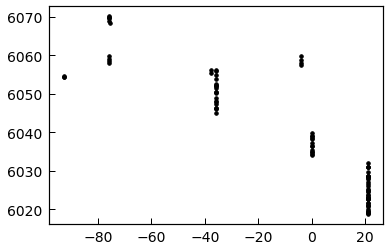

In [229]:
plt.plot(t, rv, 'k.')

(-40, -30)

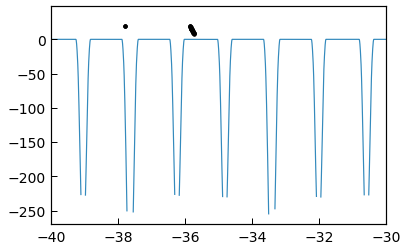

In [230]:
plt.plot(t_transit, par_wobble['light_curves'])
plt.plot(t, rv-np.median(rv), 'k.')
plt.xlim([-40,-30])

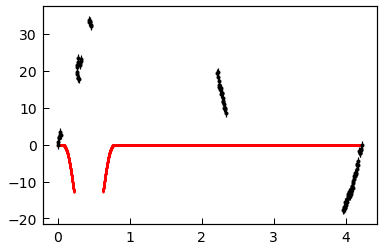

In [39]:
plt.errorbar(t % par_wobble["P"], rv - np.median(rv), rv_err, fmt='o', color='k', ms=3)
plt.plot(t_transit % par_wobble["P"], par_wobble['light_curves']/20., 'r.', ms=2)

<ErrorbarContainer object of 3 artists>

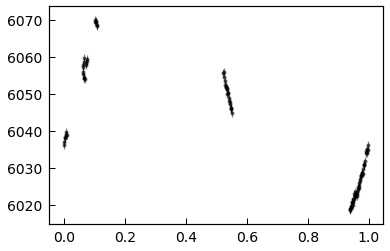

In [13]:
#pred_wobble = np.percentile(trace_wobble["rvphase"], [16, 50, 84], axis=0)
phase_wobble = (t % par_wobble["P"])/par_wobble["P"]
plt.errorbar(phase_wobble, rv - par_wobble['bkg'], 
             rv_err, fmt='o', color='k', alpha=0.5, ms=3)

In [157]:
night_mask = (phase_wobble > 0.4) & (phase_wobble < 0.6)
day_mask = (phase_wobble > 0.8) & (phase_wobble < 0.95)

In [158]:
np.sum(day_mask)

11

In [159]:
np.sum(night_mask)

20

In [160]:
r = 67
xlim = [6548, 6568]

In [206]:
r = 35
xlim = [4850, 4870]

In [207]:
from wobble.utils import doppler
day_xs = np.exp(data_51peg.xs[r][day_mask] + np.log(doppler(results_51peg.star_time_rvs[day_mask, None], tensors=False)))
day_ys = np.exp(data_51peg.ys[r][day_mask] - results_51peg.tellurics_ys_predicted[r][day_mask])
day_ivars = data_51peg.ivars[r][day_mask] # HACK!!!
night_xs = np.exp(data_51peg.xs[r][night_mask] + np.log(doppler(results_51peg.star_time_rvs[night_mask, None], tensors=False)))
night_ys = np.exp(data_51peg.ys[r][night_mask] - results_51peg.tellurics_ys_predicted[r][night_mask])
night_ivars = data_51peg.ivars[r][night_mask] # HACK!!!

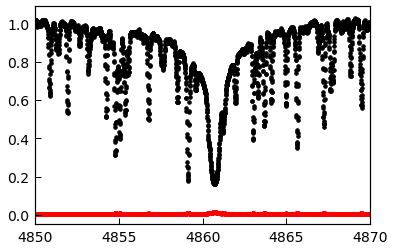

In [208]:
plt.plot(day_xs[0], day_ys[0], 'k.')
plt.plot(day_xs[10], day_ys[10], 'k.')
plt.plot(day_xs[0], 1./np.sqrt(day_ivars[0]), 'r.')
plt.xlim(xlim);

In [209]:
common_xs = np.arange(np.max(np.append(day_xs[:,0], night_xs[:,0])),
                      np.min(np.append(day_xs[:,-1], night_xs[:,-1])),
                      0.03)

In [210]:
from wobble.utils import bin_data

In [211]:
binned_day_ys = bin_data(day_xs, day_ys, day_ivars, common_xs)
binned_night_ys = bin_data(night_xs, night_ys, night_ivars, common_xs)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


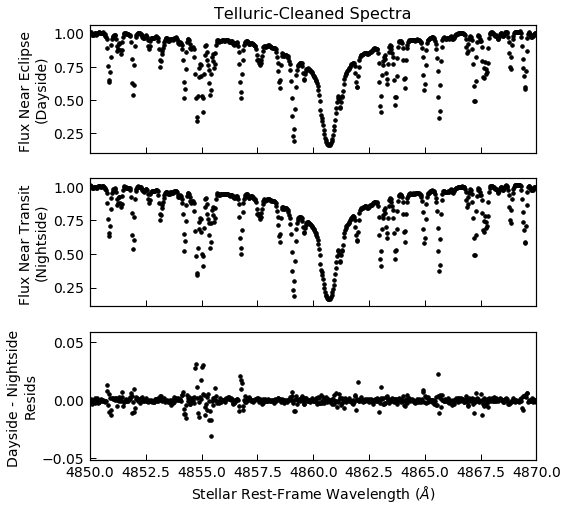

In [212]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw = {'height_ratios':[1, 1, 1]}, 
                                         figsize=(8,8), sharex=True)
ax1.plot(common_xs, binned_day_ys, 'k.')
ax1.set_ylabel('Flux Near Eclipse \n(Dayside)', fontsize=14)
ax2.plot(common_xs, binned_night_ys, 'k.')
ax2.set_ylabel('Flux Near Transit \n(Nightside)', fontsize=14)
ax3.plot(common_xs, binned_day_ys - binned_night_ys, 'k.')
ax3.set_ylabel('Dayside - Nightside \nResids', fontsize=14)
ax1.set_xlim(xlim)
ax1.set_title('Telluric-Cleaned Spectra', fontsize=16)
ax3.set_xlabel(r'Stellar Rest-Frame Wavelength ($\AA$)', fontsize=14)
fig.show()

In [213]:
day_ys = np.exp(data_51peg.ys[r][day_mask] - results_51peg.tellurics_ys_predicted[r][day_mask]
               - results_51peg.star_ys_predicted[r][day_mask])
night_ys = np.exp(data_51peg.ys[r][night_mask] - results_51peg.tellurics_ys_predicted[r][night_mask]
                 - results_51peg.star_ys_predicted[r][night_mask])
binned_day_ys = bin_data(day_xs, day_ys, day_ivars, common_xs)
binned_night_ys = bin_data(night_xs, night_ys, night_ivars, common_xs)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


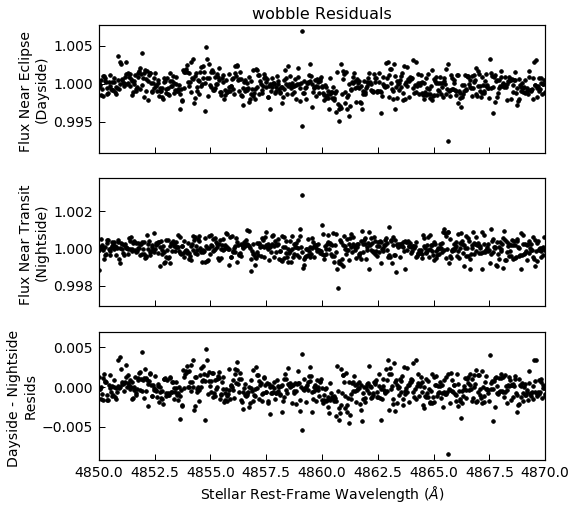

In [214]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw = {'height_ratios':[1, 1, 1]}, 
                                         figsize=(8,8), sharex=True)
ax1.plot(common_xs, binned_day_ys, 'k.')
ax1.set_ylabel('Flux Near Eclipse \n(Dayside)', fontsize=14)
ax2.plot(common_xs, binned_night_ys, 'k.')
ax2.set_ylabel('Flux Near Transit \n(Nightside)', fontsize=14)
ax3.plot(common_xs, binned_day_ys - binned_night_ys, 'k.')
ax3.set_ylabel('Dayside - Nightside \nResids', fontsize=14)
ax1.set_xlim(xlim)
ax1.set_title('wobble Residuals', fontsize=16)
ax3.set_xlabel(r'Stellar Rest-Frame Wavelength ($\AA$)', fontsize=14)
fig.show()

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


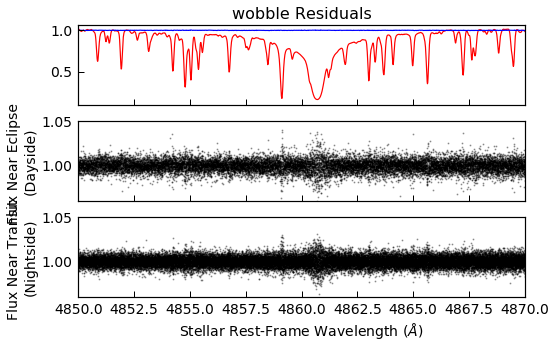

In [226]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw = {'height_ratios':[1, 1, 1]}, 
                                         figsize=(8,5), sharex=True)
ax1.plot(day_xs[0], np.exp(results_51peg.star_ys_predicted[r][day_mask][0]), c='r')
ax1.plot(day_xs[0], np.exp(results_51peg.tellurics_ys_predicted[r][day_mask][0]), c='b')
ax2.plot(day_xs, day_ys, 'k.', alpha=0.3, ms=2)
ax2.set_ylabel('Flux Near Eclipse \n(Dayside)', fontsize=14)
ax3.plot(night_xs, night_ys, 'k.', alpha=0.3, ms=2)
ax3.set_ylabel('Flux Near Transit \n(Nightside)', fontsize=14)
ax1.set_xlim(xlim)
ax1.set_title('wobble Residuals', fontsize=16)
ax3.set_xlabel(r'Stellar Rest-Frame Wavelength ($\AA$)', fontsize=14)
ax2.set_ylim([0.96,1.05])
ax3.set_ylim([0.96,1.05])
fig.show();